# ECOSTRESS data wrangling

From [AppEEARS](https://lpdaacsvc.cr.usgs.gov/appeears), I've downloaded a whole collection of geotiffs for ECOSTRESS LST for a bounding box around Clear Lake.

Next I'd like to open all those images and see if I can stack them together into a big NetCDF file or something. Then we'd have a big LST data cube to work with!

In [1]:
import os
import xarray as xr
import rioxarray as rioxr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, mapping

import matplotlib.pyplot as plt
%matplotlib inline

Set the path to the top level directory where all our ECOSTRESS images are, their file extension, and product name.

In [2]:
eco_tiff_path = '/home/jovyan/data/ECOSTRESS/'
ext = '.tif'
product = 'SDS_LST_doy'

Get a list of all our ECOSTRESS LST files

In [3]:
# get list of all tif files
file_list = []
for root, dirs, files in os.walk(eco_tiff_path):
    for file in files:
        if file.endswith(ext):
            if product in file:
                 file_list.append( os.path.join(root, file) ) 

Open one of our ECOSTRESS images

In [4]:
eco_lst = xr.open_rasterio(file_list[10])

In [5]:
eco_lst

<xarray.DataArray (band: 1, y: 283, x: 343)>
array([[[    0, 14763, ...,     0,     0],
        [    0, 14768, ..., 14962, 14974],
        ...,
        [    0,     0, ..., 14956, 14966],
        [    0,     0, ..., 14972, 14961]]], dtype=int32)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 41.95 41.95 41.95 41.95 ... 41.78 41.78 41.78 41.78
  * x        (x) float64 -121.3 -121.3 -121.3 -121.3 ... -121.0 -121.0 -121.0
Attributes:
    transform:      (0.0006308259919700716, 0.0, -121.25943596518718, 0.0, -0...
    crs:            +init=epsg:4326
    res:            (0.0006308259919700716, 0.0006308259919700716)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    add_offset:     0
    AREA_OR_POINT:  Area
    build_id:       0601
    orbit_number:   10686
    scale_factor:   0.02
    scene_id:       004
    units:          K

Open our Clear Lake shapefile

In [6]:
clearlake = gpd.read_file('zip://../data/Clear_Lake_Res.zip')
clearlake.head()

,DFGWATERID,TYPE,NAME,GNIS_NAME,GNIS_ID,COUNTY,QUAD_NAME,QUAD_CODE,LAT_NAD83,LON_NAD83,UTM_ZONE,UTM_N_N83,UTM_E_N83,MTR,elev_ft,sfc_acres,Shape_Leng,Shape_Area,geometry
0,8177,perennial,Clear Lake Reservoir,Clear Lake Reservoir,221199.0,Modoc,DOUBLE HEAD MTN.,41121G2,41.865752,-121.144879,10.0,4.636535e+06,653962.164441,M47N 07E,4484,25012.128035,110372.801128,1.012209e+08,"MULTIPOLYGON Z (((-89566.185 434787.792 0.000,..."


Are we in the same crs?

In [7]:
print('ECOSTRESS CRS: {}'.format(eco_lst.crs))
print('Shapefile CRS: {}'.format(clearlake.crs))

ECOSTRESS CRS: +init=epsg:4326
Shapefile CRS: epsg:3310


No, so let's fix it

In [8]:
clearlake = clearlake.to_crs(eco_lst.crs)

/home/jovyan/data/conda-envs/firewaterenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [9]:
print('ECOSTRESS CRS: {}'.format(eco_lst.crs))
print('Shapefile CRS: {}'.format(clearlake.crs))

ECOSTRESS CRS: +init=epsg:4326
Shapefile CRS: +init=epsg:4326 +type=crs


Scale the temperature values

In [10]:
scaled_eco_lst = eco_lst * float(eco_lst.attrs['scale_factor'])

Plot our ECOSTRESS image and Clear Lake Shapefile

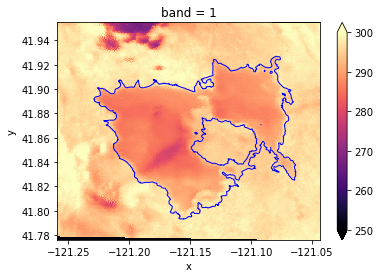

In [11]:
fig, ax = plt.subplots()

scaled_eco_lst.plot(x='x', y='y', ax=ax, vmin=250, vmax=300, cmap='magma')

clearlake.plot(ax=ax, edgecolor='blue', facecolor='none');

ax.set_aspect(1)

Mask using the Clear Lake shapefile

In [12]:
clearlake_lst = eco_lst.rio.clip(clearlake.geometry.apply(mapping))

/home/jovyan/data/conda-envs/firewaterenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [13]:
# scale our clipped dataset
scaled_clearlake_lst = clearlake_lst * float(eco_lst.attrs['scale_factor'])

Plot the clipped ECOSTRESS image

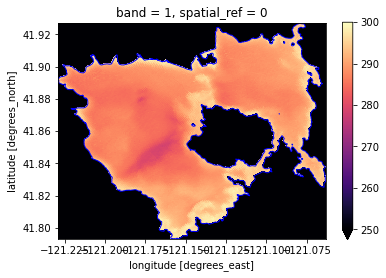

In [14]:
fig, ax = plt.subplots()

scaled_clearlake_lst.plot(x='x', y='y', ax=ax, vmin=250, vmax=300, cmap='magma')

clearlake.plot(ax=ax, edgecolor='blue', facecolor='none');

ax.set_aspect(1)